<h2>Assignment 4</h2>

<p>Assignment 4 deals with a dataset compromised of 56745 tweets. These tweets are said to be hateful or offensive and come from various sources. Therefore, the tweets contain different topics. Because of this, the analysis is guided by three main steps. In a first step, an exploratory data analysis (EDA), where the dataset is inspected, gets conducted. In a second step, a sentiment analysis will be performed. In a third step, a topic model will be applied to the textual data. The dataset is derived from this source: https://www.kaggle.com/ashwiniyer176/toxic-tweets-dataset<br>
The research interest is guided by the question how the sample is structured, how negative and opinionated it really is and if it is possible to extract meaningful topics from such a diverse sample.</p>

In [1]:
!pip install gensim textract pyLDAvis spaCy textstat textblob

In [6]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [7]:
import os
import pathlib
import time
import codecs
import string
import re
from collections import Counter
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import urllib
import requests
from bs4 import BeautifulSoup

import nltk
import networkx as nx
import gensim
from wordcloud import WordCloud
import textract
import pyLDAvis
import pyLDAvis.gensim_models
import spacy
import textstat
import textblob

from IPython.core.display import Image
%matplotlib inline

In [8]:
dfhate = pd.read_csv('FinalBalancedDataset.csv')

In [9]:
dfhate.head(5)

,Unnamed: 0,Toxicity,tweet
0,0,0,@user when a father is dysfunctional and is s...
1,1,0,@user @user thanks for #lyft credit i can't us...
2,2,0,bihday your majesty
3,3,0,#model i love u take with u all the time in ...
4,4,0,factsguide: society now #motivation


In [9]:
dfhate.tail(5)

,Unnamed: 0,Toxicity,tweet
56740,56740,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
56741,56741,1,"you've gone and broke the wrong heart baby, an..."
56742,56742,1,young buck wanna eat!!.. dat nigguh like I ain...
56743,56743,1,youu got wild bitches tellin you lies
56744,56744,0,~~Ruffled | Ntac Eileen Dahlia - Beautiful col...


In [10]:
dfhate.columns

Index(['Unnamed: 0', 'Toxicity', 'tweet'], dtype='object')

In [11]:
dfhate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56745 entries, 0 to 56744
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  56745 non-null  int64 
 1   Toxicity    56745 non-null  int64 
 2   tweet       56745 non-null  object
dtypes: int64(2), object(1)
memory usage: 1.3+ MB


<h3>Number of characters in each sentence</h3>

<AxesSubplot:>

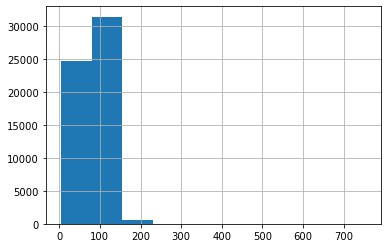

In [12]:
dfhate['tweet'].str.len().hist()

<h3>Number of words in each  tweet</h3>

In [14]:
def plot_word_number_histogram(text):
    text.str.split().\
        map(lambda x: len(x)).\
        hist()

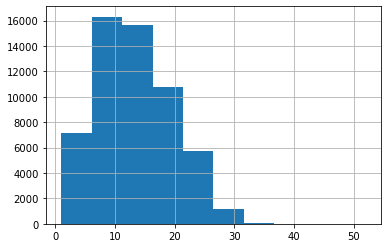

In [15]:
plot_word_number_histogram(dfhate['tweet'])

<h3>Average word length in each tweet</h3>

<AxesSubplot:>

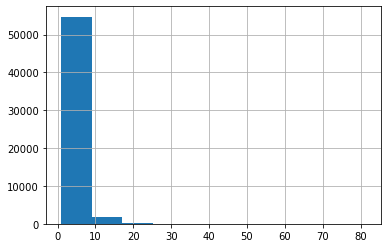

In [17]:
dfhate['tweet'].str.split().\
   apply(lambda x : [len(i) for i in x]). \
   map(lambda x: np.mean(x)).hist()

<h3>Data Cleaning and Data Preparation</h3>

In [10]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kirch\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kirch\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kirch\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\kirch\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\kirch\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [11]:
dfhate.dropna(axis='rows', subset=["tweet"], inplace=True)

In [12]:
dfhate['tweet'] += " "

In [14]:
texts = dfhate['tweet'].sum()
texts[0:1000]

" @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run @user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked   bihday your majesty #model   i love u take with u all the time in urð\x9f\x93±!!! ð\x9f\x98\x99ð\x9f\x98\x8eð\x9f\x91\x84ð\x9f\x91\x85ð\x9f\x92¦ð\x9f\x92¦ð\x9f\x92¦    factsguide: society now    #motivation [2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo    @user camping tomorrow @user @user @user @user @user @user @user dannyâ\x80¦ the next school year is the year for exams.ð\x9f\x98¯ can't think about that ð\x9f\x98\xad #school #exams   #hate #imagine #actorslife #revolutionschool #girl we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers  â\x80¦   @user @user welcome here !  i'm   it's so #gr8 !   â\x86\x9d #ireland consumer price index (mom) climbed from previous

In [15]:
stop_en = nltk.corpus.stopwords.words('english')

In [16]:
stop_en.extend(['-','', '”'])

In [17]:
list_words = texts.split()
list_words = [l.strip().lower() for l in list_words]
list_words = [l.strip(string.punctuation) for l in list_words]
list_words = [l for l in list_words if l not in stop_en]
list_words[0:20]

['user',
 'father',
 'dysfunctional',
 'selfish',
 'drags',
 'kids',
 'dysfunction',
 'run',
 'user',
 'user',
 'thanks',
 'lyft',
 'credit',
 "can't",
 'use',
 'cause',
 'offer',
 'wheelchair',
 'vans',
 'pdx']

<h3>Top 20 most common words</h3>

In [25]:
freqdist = Counter(list_words)

In [26]:
freqdist.most_common(20)

[('user', 17474),
 ('bitch', 8162),
 ('rt', 7577),
 ('like', 3801),
 ('love', 3339),
 ('bitches', 3071),
 ("i'm", 2610),
 ('day', 2526),
 ('amp', 2421),
 ('u', 2408),
 ('get', 2345),
 ('hoes', 2343),
 ('pussy', 2122),
 ('hoe', 1872),
 ('happy', 1831),
 ('got', 1816),
 ('ass', 1629),
 ('time', 1546),
 ('fuck', 1518),
 ('one', 1478)]

In [27]:
fmc = freqdist.most_common(20)

In [28]:
df = pd.DataFrame(fmc, columns=['word','count'])
print(df)

       word  count
0      user  17474
1     bitch   8162
2        rt   7577
3      like   3801
4      love   3339
5   bitches   3071
6       i'm   2610
7       day   2526
8       amp   2421
9         u   2408
10      get   2345
11     hoes   2343
12    pussy   2122
13      hoe   1872
14    happy   1831
15      got   1816
16      ass   1629
17     time   1546
18     fuck   1518
19      one   1478


<AxesSubplot:xlabel='word'>

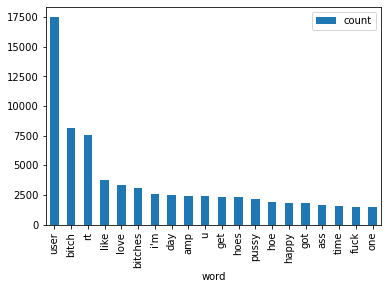

In [29]:
df.plot(x ='word', y='count', kind = 'bar')

<h3>Wordcloud of most frequent words</h3>

In [30]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [31]:
wordcloud = WordCloud(background_color="white").generate(texts)

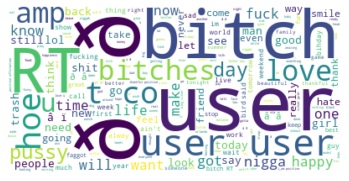

In [32]:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

<h3>Further Data Preparation</h3>

In [33]:
stop = set(nltk.corpus.stopwords.words('english'))

In [34]:
corpus=[]
new = dfhate['tweet'].str.split()
new = new.values.tolist()
corpus = [word for i in new for word in i]

<BarContainer object of 10 artists>

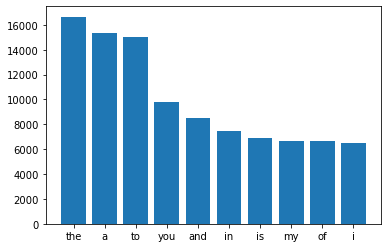

In [35]:
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1
top = sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y = zip(*top)
plt.bar(x,y)

<h3>N-Grams</h3>

In [37]:
from nltk.util import ngrams

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

<AxesSubplot:>

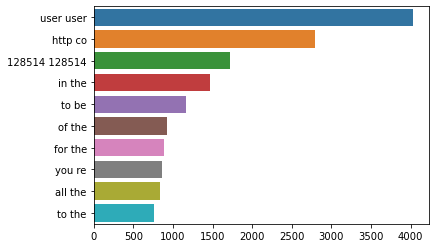

In [39]:
top_n_bigrams=get_top_ngram(dfhate['tweet'],2)[:10]
x,y = map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

<AxesSubplot:>

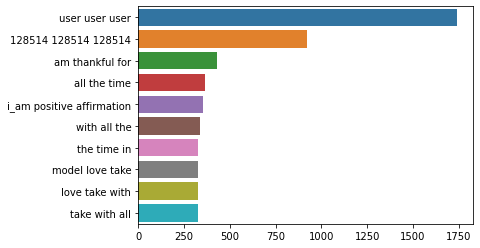

In [40]:
top_tri_grams=get_top_ngram(dfhate['tweet'],n=3)
x,y = map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)

<h3>EDA with SpaCy</h3>

In [17]:
!pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy validate

[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')

| Loading compatibility table...
[+] Loaded compatibility table

================= Installed pipeline packages (spaCy v3.0.6) =================
[i] spaCy installation: C:\Users\kirch\anaconda3\lib\site-packages\spacy

NAME             SPACY            VERSION      
en_core_web_sm   >=3.0.0,<3.1.0   3.0.0     [+]



In [16]:
en_nlp = spacy.load('en_core_web_sm', exclude=["ner"])

In [17]:
en_nlp.max_length = 4882555

In [18]:
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser"])

In [20]:
nlp.enable_pipe("tagger")

In [21]:
en_doc = en_nlp(texts)

<h4>Part of Speech</h4>

In [23]:
tagDict = {w.pos: w.pos_ for w in en_doc} 
tagDict

{103: 'SPACE',
 86: 'ADV',
 90: 'DET',
 92: 'NOUN',
 100: 'VERB',
 84: 'ADJ',
 89: 'CCONJ',
 95: 'PRON',
 85: 'ADP',
 97: 'PUNCT',
 93: 'NUM',
 87: 'AUX',
 94: 'PART',
 98: 'SCONJ',
 96: 'PROPN',
 101: 'X',
 99: 'SYM',
 91: 'INTJ'}

<AxesSubplot:>

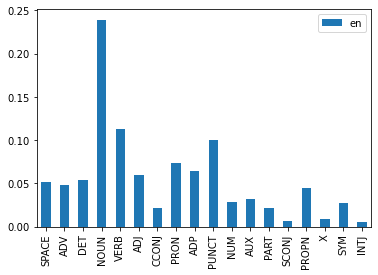

In [24]:
en_docPOS = pd.Series(en_doc.count_by(spacy.attrs.POS))/len(en_doc)

df = pd.DataFrame([en_docPOS], index=['en'])
df.columns = [tagDict[column] for column in df.columns]
df.T.plot(kind='bar')

In [28]:
en_docNouns = [w for w in en_doc if w.pos_ == 'NOUN']
Counter([w.text.strip() for w in en_docNouns]).most_common(10)

[('#', 33854),
 ('bitch', 7172),
 ('bitches', 2549),
 ('day', 2534),
 ('amp', 2338),
 ('u', 2045),
 ('pussy', 1949),
 ('hoes', 1892),
 ('hoe', 1689),
 ('ass', 1590)]

<h4>The nouns are almost all negatively connotated or offensive.</h4>

In [30]:
en_docAdj = [w for w in en_doc if w.pos_ == 'ADJ']
Counter([w.text.strip() for w in en_docAdj]).most_common(10)

[('happy', 1775),
 ('good', 1276),
 ('new', 1215),
 ('positive', 936),
 ('thankful', 921),
 ('@user', 763),
 ('more', 679),
 ('bad', 677),
 ('#', 629),
 ('best', 616)]

<h4>The adjectives are almost all positively connotated.</h4>

In [32]:
en_docVerb = [w for w in en_doc if w.pos_ == 'VERB']
Counter([w.text.strip() for w in en_docVerb]).most_common(10)

[('be', 3739),
 ('have', 2017),
 ('get', 1987),
 ('got', 1932),
 ('love', 1814),
 ("'m", 1790),
 ('do', 1410),
 ('is', 1307),
 ('know', 1209),
 ('go', 1206)]

<h4>The adjectives are almost all positively connotated or neutral.</h4>

<h3>EDA with regular expressions</h3>

In [141]:
hashtags = re.findall('\#\w+', texts)

In [108]:
string = str(hashtags)

In [110]:
string_split = string.split()

In [118]:
from collections import Counter

In [119]:
Counters_found = Counter(string_split)

In [124]:
most_occur = Counters_found.most_common(25)
print(most_occur)

[("'#128514',", 3241), ("'#8220',", 1726), ("'#8221',", 1681), ("'#love',", 1544), ("'#8230',", 1265), ("'#positive',", 874), ("'#128557',", 616), ("'#healthy',", 571), ("'#smile',", 549), ("'#thankful',", 492), ("'#fun',", 434), ("'#life',", 406), ("'#128553',", 368), ("'#summer',", 367), ("'#model',", 365), ("'#affirmation',", 363), ("'#cute',", 355), ("'#i_am',", 352), ("'#blog',", 346), ("'#me',", 336), ("'#fathersday',", 333), ("'#128175',", 311), ("'#silver',", 299), ("'#gold',", 298), ("'#altwaystoheal',", 295)]


In [126]:
dfhash = pd.DataFrame(most_occur, columns=['hashtag','count'])
print(df)

              hashtag  count
0          '#128514',   3241
1            '#8220',   1726
2            '#8221',   1681
3            '#love',   1544
4            '#8230',   1265
5        '#positive',    874
6          '#128557',    616
7         '#healthy',    571
8           '#smile',    549
9        '#thankful',    492
10            '#fun',    434
11           '#life',    406
12         '#128553',    368
13         '#summer',    367
14          '#model',    365
15    '#affirmation',    363
16           '#cute',    355
17           '#i_am',    352
18           '#blog',    346
19             '#me',    336
20     '#fathersday',    333
21         '#128175',    311
22         '#silver',    299
23           '#gold',    298
24  '#altwaystoheal',    295


<AxesSubplot:xlabel='hashtag'>

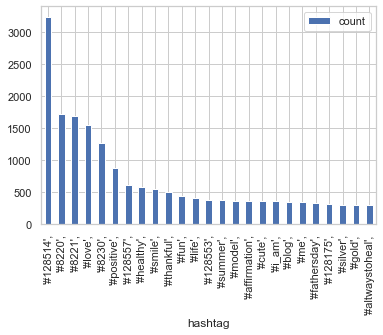

In [138]:
dfhash.plot(x ='hashtag', y='count', kind = 'bar')

<h4>Interestingly, the 25 most common hashtags are all associated with positivity.</h4>

<h3>As exclamation marks often signal strong opinions, I count for one or more exclamation marks</h3>

In [146]:
exclamations = re.findall('\!{1,}', texts)

In [147]:
exclam = string = str(exclamations)

In [148]:
string_split = exclam.split()

In [149]:
Counters_found = Counter(string_split)

In [152]:
most_occur = Counters_found.most_common(10)
print(most_occur)

[("'!',", 9331), ("'!!',", 1738), ("'!!!',", 1249), ("'!!!!',", 260), ("'!!!!!',", 84), ("'!!!!!!',", 42), ("'!!!!!!!',", 21), ("'!!!!!!!!',", 15), ("'!!!!!!!!!',", 6), ("'!!!!!!!!!!!!!',", 5)]


In [154]:
dfexcl = pd.DataFrame(most_occur, columns=['exclamation','count'])
print(dfexcl)

        exclamation  count
0              '!',   9331
1             '!!',   1738
2            '!!!',   1249
3           '!!!!',    260
4          '!!!!!',     84
5         '!!!!!!',     42
6        '!!!!!!!',     21
7       '!!!!!!!!',     15
8      '!!!!!!!!!',      6
9  '!!!!!!!!!!!!!',      5


<AxesSubplot:xlabel='exclamation'>

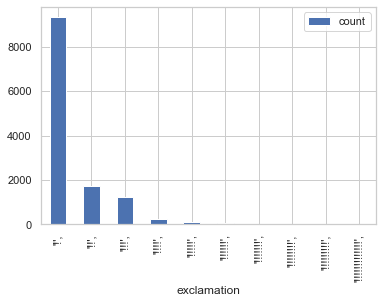

In [158]:
dfexcl.plot(x ='exclamation', y='count', kind = 'bar')

<h4>After the EDA, a sentiment analysis is applied to the data, analysing the polarization and opinionation of the dataset.</h4>

<h3>Sentiment Analysis</h3>

In [23]:
import math
from math import fsum

In [24]:
from textblob import TextBlob
from textblob import Word

In [25]:
blob = TextBlob(texts)
blob_en = TextBlob(texts)

<h4>sum of sentiments</h4>

In [26]:
sent_sum = 0
for sentence in blob.sentences:
     sent_sum += (sentence.sentiment.polarity)
print(sent_sum)

4156.229921801944


<h4>average sentiment per sentence</h4>

In [27]:
result_pol = []
for sentence in blob.sentences:
    result_pol.append(sentence.sentiment.polarity)

In [28]:
import statistics

In [29]:
mean = statistics.mean(result_pol)
print(mean)

0.10704208101889931


<h5>As observed, the sentiment analysis suggests, that neither the summed sentiment value for the whole dataset nor the average sentiment value per sentence are negative.</h5>

<h3>Degree of opinionation</h3>

In [30]:
sent_sum = 0
for sentence in blob.sentences:
     sent_sum += (sentence.sentiment.subjectivity)
print(sent_sum)

15093.58939035064


In [31]:
result_sub = []
for sentence in blob.sentences:
    result_sub.append(sentence.sentiment.subjectivity)

In [32]:
mean = statistics.mean(result_sub)
print(mean)

0.38872950938370726


In [33]:
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

In [34]:
dfhate['polarity'] = dfhate['tweet'].apply(pol)
dfhate['subjectivity'] = dfhate['tweet'].apply(sub)

In [54]:
dfhate.head()

,Unnamed: 0,Toxicity,tweet,polarity,subjectivity
0,0,0,@user when a father is dysfunctional and is s...,-0.500000,1.0
1,1,0,@user @user thanks for #lyft credit i can't us...,0.200000,0.2
2,2,0,bihday your majesty,0.000000,0.0
3,3,0,#model i love u take with u all the time in ...,0.976562,0.6
4,4,0,factsguide: society now #motivation,0.000000,0.0


In [70]:
number_of_characters = lambda x: len(x)

In [71]:
dfhate['characters'] = dfhate['tweet'].apply(number_of_characters)

In [57]:
dfhate.head()

,Unnamed: 0,Toxicity,tweet,polarity,subjectivity,characters
0,0,0,@user when a father is dysfunctional and is s...,-0.500000,1.0,103
1,1,0,@user @user thanks for #lyft credit i can't us...,0.200000,0.2,123
2,2,0,bihday your majesty,0.000000,0.0,22
3,3,0,#model i love u take with u all the time in ...,0.976562,0.6,87
4,4,0,factsguide: society now #motivation,0.000000,0.0,40


In [58]:
statistics.mean(dfhate['characters'])

86.04379240461715

<AxesSubplot:xlabel='characters'>

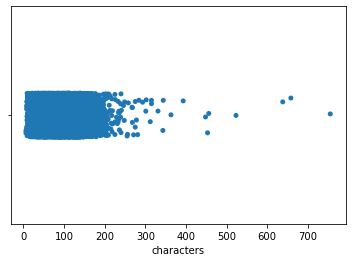

In [59]:
sns.stripplot(x=dfhate['characters'])

<AxesSubplot:xlabel='polarity'>

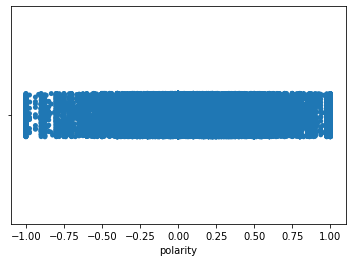

In [60]:
sns.stripplot(x=dfhate['polarity'])

<AxesSubplot:xlabel='subjectivity'>

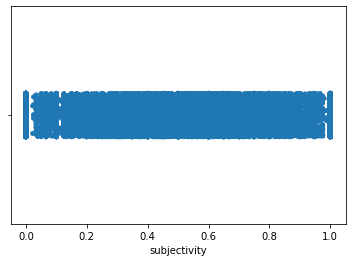

In [61]:
sns.stripplot(x=dfhate['subjectivity'])

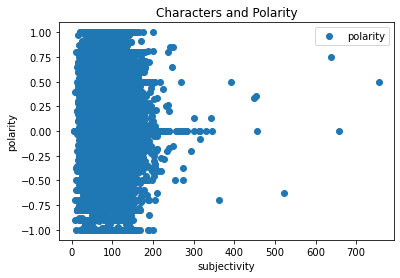

In [62]:
dfhate.plot(x='characters', y='polarity', style='o')  
plt.title('Characters and Polarity')  
plt.xlabel('subjectivity')  
plt.ylabel('polarity')  
plt.show()

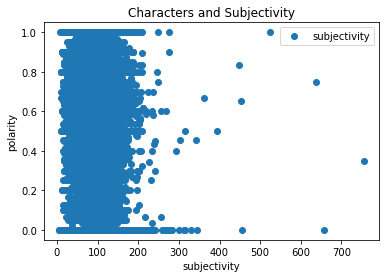

In [63]:
dfhate.plot(x='characters', y='subjectivity', style='o')  
plt.title('Characters and Subjectivity')  
plt.xlabel('subjectivity')  
plt.ylabel('polarity')  
plt.show()

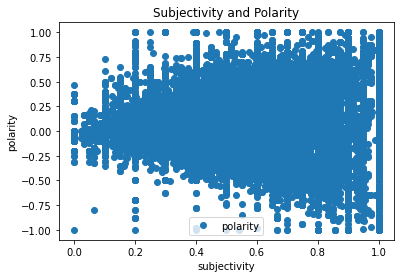

In [64]:
dfhate.plot(x='subjectivity', y='polarity', style='o')  
plt.title('Subjectivity and Polarity')  
plt.xlabel('subjectivity')  
plt.ylabel('polarity')  
plt.show()

<h3>Correlations between word length, polarity and subjectivity, using the pearson correlation coefficient. </h3>

In [90]:
from scipy.stats.stats import pearsonr

In [66]:
pearsonr(dfhate['characters'], dfhate['polarity'])

(0.006694615573038035, 0.11077461560890205)

<p>There is no statistically significant correlation between the number of characters and the polarity of the tweet.</p>

In [67]:
pearsonr(dfhate['characters'], dfhate['subjectivity'])

(0.164525005732572, 0.0)

<p>There is a weak (0.1645) but significant (p < .05) positive correlation between the number of characters and the subjectivity of a tweet.</p>

In [68]:
pearsonr(dfhate['subjectivity'], dfhate['polarity'])

(0.1698102753273882, 0.0)

<p>There is a weak (0.1698) but significant (p < .05) positive correlation between the subjectivtiy and the polarity of a tweet.</p>

<h3>Distribution of Polarity and Subjectivity in the texts</h3>

<BarContainer object of 3 artists>

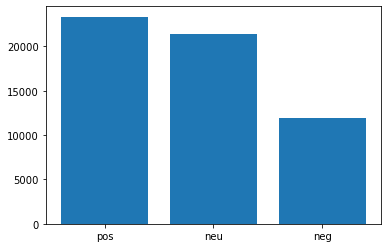

In [36]:
def sentiment(x):
    if x<0:
        return 'neg'
    elif x==0:
        return 'neu'
    else:
        return 'pos'
    
dfhate['polarity']=dfhate['polarity'].\
   map(lambda x: sentiment(x))

plt.bar(dfhate.polarity.value_counts().index,
        dfhate.polarity.value_counts())

<AxesSubplot:>

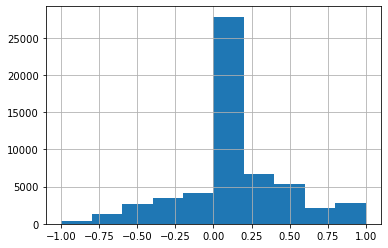

In [52]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

dfhate['polarity_score']=dfhate['tweet'].\
   apply(lambda x : polarity(x))
dfhate['polarity_score'].hist()

<AxesSubplot:>

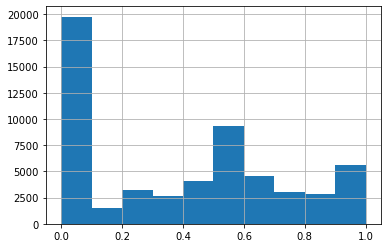

In [76]:
dfhate['subjectivity'].hist()

In [83]:
dfhate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56745 entries, 0 to 56744
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      56745 non-null  int64  
 1   Toxicity        56745 non-null  int64  
 2   tweet           56745 non-null  object 
 3   polarity        56745 non-null  object 
 4   subjectivity    56745 non-null  float64
 5   polarity_score  56745 non-null  float64
 6   characters      56745 non-null  int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 3.5+ MB


In [84]:
dfhate.head()

,Unnamed: 0,Toxicity,tweet,polarity,subjectivity,polarity_score,characters
0,0,0,@user when a father is dysfunctional and is s...,neg,1.0,-0.500000,103
1,1,0,@user @user thanks for #lyft credit i can't us...,pos,0.2,0.200000,123
2,2,0,bihday your majesty,neu,0.0,0.000000,22
3,3,0,#model i love u take with u all the time in ...,pos,0.6,0.976562,87
4,4,0,factsguide: society now #motivation,neu,0.0,0.000000,40


<AxesSubplot:>

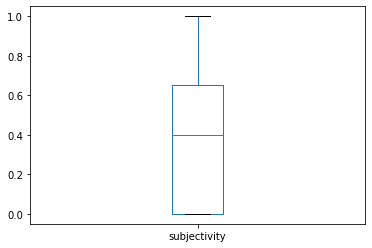

In [62]:
(dfhate['subjectivity']).plot.box(x = dfhate['tweet'], y = dfhate['subjectivity'])

<AxesSubplot:>

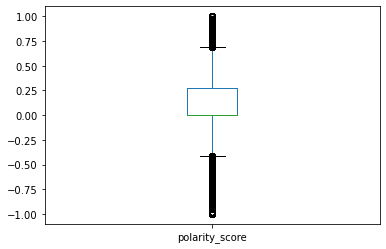

In [58]:
dfhate['polarity_score'].plot.box(x = dfhate['tweet'], y = dfhate['polarity_score'])

<AxesSubplot:ylabel='Density'>

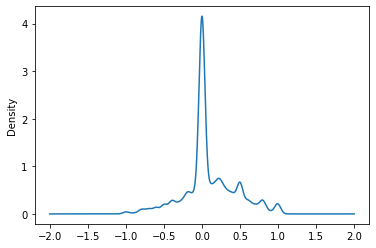

In [82]:
dfhate['polarity_score'].plot.kde(x = dfhate['tweet'], y = dfhate['polarity_score'])

<AxesSubplot:ylabel='Density'>

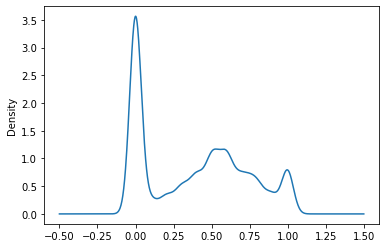

In [85]:
dfhate['subjectivity'].plot.kde(x = dfhate['tweet'], y = dfhate['subjectivity'])

<h3>Topic Modelling</h3>

<h4>Two different, but similar approaches are used to perform the topic modelling.</h4>

In [178]:
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

doc_clean = [clean(doc).split() for doc in list_words]

In [179]:
import gensim
from gensim import corpora

In [180]:
dictionary = corpora.Dictionary(doc_clean)

In [181]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

In [182]:
Lda = gensim.models.ldamodel.LdaModel

In [183]:
ldamodel = Lda(doc_term_matrix, num_topics=3, id2word = dictionary, passes=5)

In [185]:
print(ldamodel.print_topics(num_topics=3, num_words=5))

[(0, '0.039*"like" + 0.021*"get" + 0.019*"u" + 0.012*"know" + 0.011*"yo"'), (1, '0.099*"rt" + 0.062*"hoe" + 0.017*"trash" + 0.011*"amp" + 0.008*"go"'), (2, '0.143*"bitch" + 0.025*"nigga" + 0.024*"pussy" + 0.021*"im" + 0.018*"as"')]


In [198]:
def preprocess_tweets(df):
    corpus = []
    stem = nltk.stem.PorterStemmer()
    lem = nltk.stem.WordNetLemmatizer()
    for word in list_words:
        words=[w for w in nltk.tokenize.word_tokenize(word) if (w not in stop)]
        words=[lem.lemmatize(w) for w in words if len(w)>2]
        corpus.append(words)
    return corpus

corpus = preprocess_tweets(tweet)

In [199]:
dic = gensim.corpora.Dictionary(corpus)
bow_corpus = [dic.doc2bow(doc) for doc in corpus]

In [201]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics = 4, id2word = dic, passes = 10, workers = 2,  per_word_topics=True)
lda_model.show_topics()

[(0,
  '0.185*"bitch" + 0.055*"http" + 0.026*"got" + 0.016*"8221" + 0.013*"girl" + 0.009*"good" + 0.008*"y\'all" + 0.008*"never" + 0.007*"people" + 0.006*"said"'),
 (1,
  '0.094*"hoe" + 0.030*"as" + 0.020*"amp" + 0.019*"lol" + 0.015*"love" + 0.013*"fucking" + 0.013*"make" + 0.012*"need" + 0.012*"look" + 0.011*"man"'),
 (2,
  '0.059*"like" + 0.027*"fuck" + 0.018*"know" + 0.015*"one" + 0.015*"want" + 0.013*"say" + 0.012*"bad" + 0.011*"day" + 0.011*"think" + 0.010*"really"'),
 (3,
  '0.044*"128514" + 0.032*"nigga" + 0.031*"pussy" + 0.025*"8230" + 0.023*"n\'t" + 0.023*"get" + 0.019*"shit" + 0.018*"trash" + 0.016*"8220" + 0.009*"bird"')]

<h4>As apprehended, the dataset is too diverse in topics while using similar offensive language, which makes it difficult to extract meaningful topics.</h4>